# Q4: Team-Level Stats and Their Relationship to Wins

This notebook analyzes team-level performance metrics and evaluates their contribution to overall success.

We examine metrics such as:

- Team rebounds per game
- Team assists per game
- Team turnovers
- Shooting percentages (FG%, 3P%, FT%)

## step 1: import libraries and load data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("data/player_game_stats_clean.csv")


## step 2: aggregate player stats to team-level stats

In [9]:
# Aggregate to team-game level: one row per (GameKey, Team)
team = (
    df.groupby(["GameKey", "Tm"], as_index=False)
      .agg({
          "Win": "first",
          "TRB": "sum",
          "AST": "sum",
          "TOV": "sum",
          "FG": "sum", "FGA": "sum",
          "3P": "sum", "3PA": "sum",
          "FT": "sum", "FTA": "sum",
      })
)

# Recompute team shooting percentages
team["FG_pct"] = team["FG"] / team["FGA"].replace({0: np.nan})
team["3P_pct"] = team["3P"] / team["3PA"].replace({0: np.nan})
team["FT_pct"] = team["FT"] / team["FTA"].replace({0: np.nan})

# Keep rows with valid percentages
team = team.dropna(subset=["FG_pct", "3P_pct", "FT_pct"]).reset_index(drop=True)


## step 3: exploratory data analysis (EDA) of team stats vs wins

In [10]:
features = ["TRB", "AST", "TOV", "FG_pct", "3P_pct", "FT_pct"]

summary = team.groupby("Win")[features].mean()
summary.index = ["Loss (0)", "Win (1)"]
summary

,TRB,AST,TOV,FG_pct,3P_pct,FT_pct
Loss (0),42.340287,24.722295,14.392438,0.441887,0.330917,0.770828
Win (1),45.904824,28.104302,13.031291,0.490684,0.387138,0.790010


## step 4: heatmap

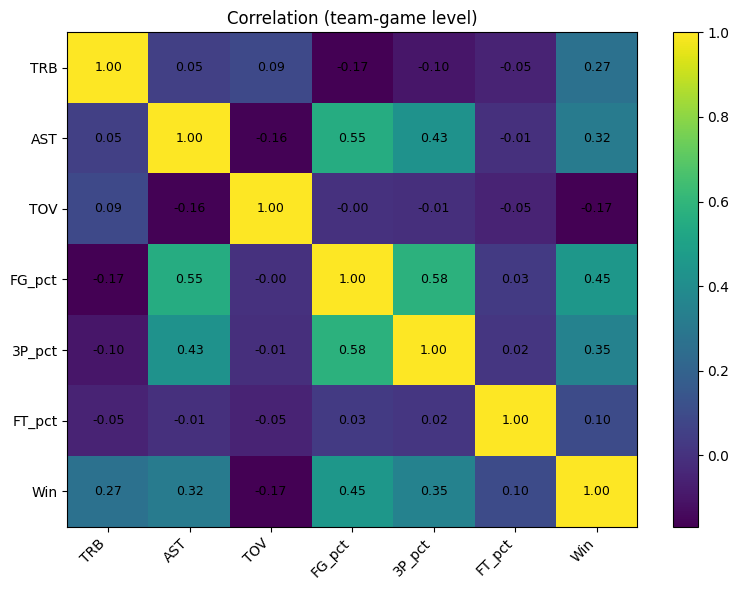

In [14]:
cols = features + ["Win"]
corr = team[cols].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Correlation (team-game level)")

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()


step 5: Logistic Regression + 5-fold CV

In [12]:
X = team[features].copy()
y = team["Win"].astype(int)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")

print(f"5-fold CV accuracy: mean={acc.mean():.3f}, std={acc.std():.3f}")


5-fold CV accuracy: mean=0.786, std=0.010


step 6: fit model and evaluate

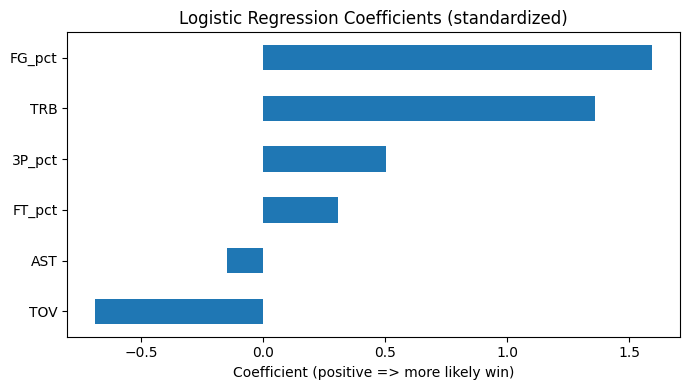

TOV      -0.686215
AST      -0.146595
FT_pct    0.308299
3P_pct    0.505695
TRB       1.359326
FG_pct    1.593972
dtype: float64

In [13]:
pipe.fit(X, y)

coefs = pd.Series(pipe.named_steps["clf"].coef_[0], index=features).sort_values()
plt.figure(figsize=(7,4))
coefs.plot(kind="barh")
plt.title("Logistic Regression Coefficients (standardized)")
plt.xlabel("Coefficient (positive => more likely win)")
plt.tight_layout()
plt.show()

coefs


## Summary of Findings
Using team-game aggregates, we model win/loss with logistic regression using rebounds, assists, turnovers, and shooting percentages.
5-fold cross validation yields an accuracy around 0.786 ± 0.010.
Coefficients suggest that turnovers reduce win probability while shooting efficiency (FG%, 3P%) increases win probability (with FG% showing the strongest positive effect in our standardized model).